### Neural Network Architecture
* (3x3) | 32
* (3x3) | 64
* Dense | 64
* Dense | 64
* Dense | 4

### Training Set
* 7033 : Eye Centers

In [20]:
!ls

datalab  drive


In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
!pip install -q keras

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import BatchNormalization, Conv2D, Activation, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras import optimizers
from sklearn.utils import shuffle

Using TensorFlow backend.


In [0]:
df = pd.read_csv("drive/facial-landmark-detection/training.csv")

In [6]:
df.shape

(7049, 31)

In [7]:
df2 = df.iloc[:,[0,1,2,3,30]]
df2 = df2.dropna()
df2.shape

(7033, 5)

In [8]:
imageStringList = []
imageStringList.extend(df2.loc[:,"Image"])

# converting the strings to numpy arrays
print "[INFO] Converting string enteries to images"
imageList = []
index=0
for s in imageStringList:
	imageList.append(np.array([int (e) for e in s.split(" ")]).reshape((96,96)))
	index = index + 1
	if index%500 == 0 :
		print str(index) + " images converted"

[INFO] Converting string enteries to images
500 images converted
1000 images converted
1500 images converted
2000 images converted
2500 images converted
3000 images converted
3500 images converted
4000 images converted
4500 images converted
5000 images converted
5500 images converted
6000 images converted
6500 images converted
7000 images converted


In [0]:
def invert(X1):
    xTemp = np.copy(X1)
    xTemp2 = np.copy(xTemp)
    
    for i in range(0,len(X1)) :
        xTemp2[i,:,:,0] = np.copy(np.fliplr(xTemp[i,:,:,0]))
    
    return xTemp2

def swap(Y):
    YTemp = np.copy(Y)

    col0 = np.copy(Y[:,0])
    col2 = np.copy(Y[:,2])
    YTemp[:,0] = col2
    YTemp[:,2] = col0
    
    col1 = np.copy(Y[:,1])
    col3 = np.copy(Y[:,3])
    YTemp[:,1] = col3
    YTemp[:,3] = col1
    
    return YTemp
  
def generate(modelDict) :
    # plotting the loss and metric for the model
    ax1 = plt.subplot(2,1,1)
    plt.plot(modelDict['mean_absolute_error'], linestyle='--', marker='o', color='b')
    plt.plot(modelDict['val_mean_absolute_error'], linestyle='--', marker='o', color='g')
    level1 = modelDict['mean_absolute_error'][0]
    level2 = modelDict['mean_absolute_error'][0] - 0.01
    i = 0
    for e in modelDict['mean_absolute_error']:
        if i%100==99 :
            e = round(e,4)
            ax1.annotate('('+str(i)+','+str(e)+')', xy=(i,level1), textcoords='data',color='b')
        i = i+1
    i = 0
    for e in modelDict['val_mean_absolute_error']:
        if i%100==99 :
            e = round(e,4)
            ax1.annotate('('+str(i)+','+str(e)+')', xy=(i,level2), textcoords='data',color='g')
        i = i+1
    plt.title('MAE | mean absolute error')
    plt.ylabel('mae')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower left')

    ax2 = plt.subplot(2,1,2)
    plt.plot(modelDict['loss'], linestyle='--', marker='o', color='b')
    plt.plot(modelDict['val_loss'], linestyle='--', marker='o', color='g')
    level1 = modelDict['loss'][0]
    level2 = modelDict['loss'][0] - 0.01
    i = 0
    for e in modelDict['loss']:
        if i%100==99 :
            e = round(e,4)
            ax2.annotate('('+str(i)+','+str(e)+')', xy=(i,level1), textcoords='data',color='b')
        i = i+1
    i = 0
    for e in modelDict['val_loss']:
        if i%100==99 :
            e = round(e,4)
            ax2.annotate('('+str(i)+','+str(e)+')', xy=(i,level2), textcoords='data',color='g')
        i = i+1
    plt.title('MSE | mean squared error')
    plt.ylabel('mse')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower left')

    # exporting the plot
    plt.tight_layout()
    fig = plt.gcf()
    fig.set_size_inches((16,9), forward=False)
    plt.show()

In [0]:
# preparing the training data
# input
X_temp = np.stack(imageList,axis=0)
X1 = X_temp.astype(np.float32)[:,:,:,np.newaxis] 				    # X1.shape = (7033,96,96,1)
X2 = invert(X1)                                             # X2.shape = (7033,96,96,1)
#X = np.concatenate((X1,X2),axis=0)
X=X1
# output
Y1 = np.stack(df2.iloc[:,range(0,4)].values,axis=0) 	      # Y1.shape(7033,4)
Y2 = swap(Y1)                                               # Y2.shape(7033,4)
#Y = np.concatenate((Y1,Y2),axis=0)
Y=Y1
# scaling input range to [0,1] from [0,255]
X = X.astype(np.float32)
X = X/255.0

# scaling target values to [-1,1] from [0,95]
Y = Y.astype(np.float32)
Y = (Y - 48.0)/48.0

In [11]:
X.shape

(7033, 96, 96, 1)

In [12]:
Y.shape

(7033, 4)

In [0]:
X, Y = shuffle(X, Y, random_state=42)  # shuffle data

In [14]:
# creating the ann model
model = Sequential()

model.add(BatchNormalization(input_shape=(96,96,1)))
# (96,96,1)

model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
# (47,47,32)

model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
# (22,22,64)

model.add(Flatten())

model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dense(4))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 96, 96, 1)         4         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 94, 94, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 94, 94, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 45, 45, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0         
__________

[INFO] Training
Train on 5626 samples, validate on 1407 samples
Epoch 1/1000
5626/5626 [==============================] - 5s 972us/step - loss: 0.0028 - mean_absolute_error: 0.0321 - val_loss: 0.0029 - val_mean_absolute_error: 0.0347
Epoch 2/1000
5626/5626 [==============================] - 5s 957us/step - loss: 0.0024 - mean_absolute_error: 0.0298 - val_loss: 0.0023 - val_mean_absolute_error: 0.0304
Epoch 3/1000
5626/5626 [==============================] - 5s 948us/step - loss: 0.0020 - mean_absolute_error: 0.0278 - val_loss: 0.0021 - val_mean_absolute_error: 0.0288
Epoch 4/1000
5626/5626 [==============================] - 5s 953us/step - loss: 0.0018 - mean_absolute_error: 0.0262 - val_loss: 0.0021 - val_mean_absolute_error: 0.0298
Epoch 5/1000
5626/5626 [==============================] - 5s 961us/step - loss: 0.0015 - mean_absolute_error: 0.0253 - val_loss: 0.0023 - val_mean_absolute_error: 0.0327
Epoch 6/1000
5626/5626 [==============================] - 5s 952us/step - loss: 0.0012

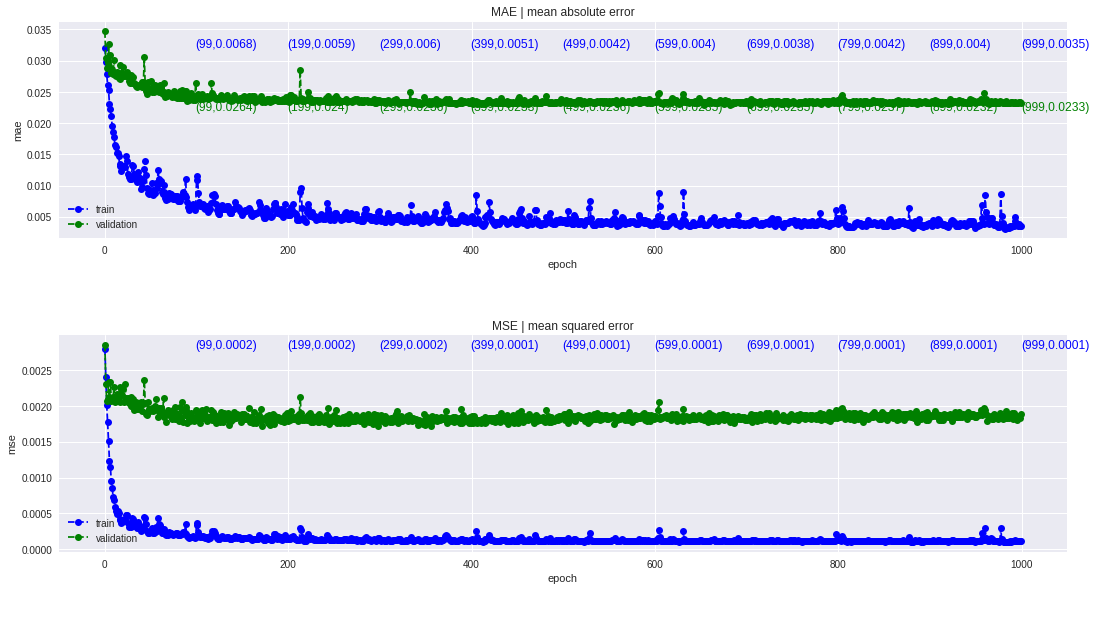

In [18]:
print "[INFO] Training"
hist = model.fit(X, Y, validation_split=0.2, shuffle=True, epochs=1000, batch_size=32)
generate(hist.history)
model.save('drive/facial-landmark-detection/CNN_4_1000.h5')

In [23]:
print "[INFO] Training"
hist = model.fit(X, Y, validation_split=0.2, shuffle=True, epochs=1000, batch_size=16)
generate(hist.history)
model.save('drive/facial-landmark-detection/CNN_4_2000.h5')

[INFO] Training
Train on 5626 samples, validate on 1407 samples
Epoch 1/1000


InternalError: ignored